# Project Proposal: Study of the Links Between Gold Market and US Debt & FED Rates

### This project aims to explore the relationships between the gold market, US debt, and Federal Reserve (FED) rates using machine learning techniques. By analyzing historical data and applying various ML models, we hope to uncover patterns and insights that can inform portfolio management and trading strategies.

Authors : Paul-Antoine FRUCHTENREICH & Bilal BENHANA 
Date : 2024

In [ ]:
pip install kagglehub

In [ ]:
import requests
import json
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import datetime

In [30]:
# Dictionary to map dataset IDs to their corresponding endpoints

dataset_endpoints = {
    'debt_to_penny': 'https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v2/accounting/od/debt_to_penny',
    'average_interest_rate': 'https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v2/accounting/od/avg_interest_rates',
    'tips_cpi': 'https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v1/accounting/od/tips_cpi_data_detail'
}

def fetch_data(dataset_id, start_date, end_date, sort='record_date'):
    """
    Fetch data from the specified dataset endpoint with optional parameters.

    :param dataset_id: str, ID of the dataset to fetch (e.g., 'debt_to_penny', 'average_interest_rate', 'tips_cpi')
    :param start_date: str, start date for the data in 'YYYY-MM-DD' format
    :param end_date: str, end date for the data in 'YYYY-MM-DD' format
    :param sort: str, field to sort the data by (default is 'record_date')
    :return: dict, JSON response from the API
    """
    days = (datetime.datetime.strptime(end_date, '%Y-%m-%d') - datetime.datetime.strptime(start_date, '%Y-%m-%d')).days
    
    if days > 10000:
        raise ValueError(f"The maximum range of data that can be fetched is 10000 days (approximately 27 years). Here, the range is {days} days. (approximately {days//365} years).")

    if dataset_id not in dataset_endpoints:
        raise ValueError(f"Invalid dataset_id. Available options are: {list(dataset_endpoints.keys())}")

    url = dataset_endpoints[dataset_id]
    params = {
        'filter': f'{sort}:gte:{start_date},{sort}:lte:{end_date}',
        'sort': sort,
        'page[number]': 1,
        'page[size]': days
    }
    response = requests.get(url, params=params)

    if response.status_code != 200:
        raise Exception(f"Failed to fetch data: {response.status_code} - {response.text}")

    df = pd.DataFrame(json.loads(response.text)['data'])
    return df

# Example usage:

"""
debt_to_penny_df = fetch_data('debt_to_penny', '2020-01-01', '2021-01-01')
average_interest_rate_df = fetch_data('average_interest_rate', '2020-01-01', '2021-01-01')
tips_cpi_df = fetch_data('tips_cpi', '1998-01-01', '2020-01-01', sort='original_issue_date')
"""

"\ndebt_to_penny_df = fetch_data('debt_to_penny', '2020-01-01', '2021-01-01')\naverage_interest_rate_df = fetch_data('average_interest_rate', '2020-01-01', '2021-01-01')\ntips_cpi_df = fetch_data('tips_cpi', '1998-01-01', '2020-01-01', sort='original_issue_date')\n"

## Load gold prices and US debt data

### Load the gold price data into a DataFrame

In [ ]:
# Download kaggle dataset of gold price from 1979 to present on a daily basis
path = kagglehub.dataset_download("jishnukoliyadan/gold-price-1979-present")

In [80]:
gold_data = pd.read_csv(path + "/Daily_Gold_Price_on_World.csv")
gold_data_usd = gold_data[["Date", "US dollar (USD)"]]
gold_data_usd['Date'] = pd.to_datetime(gold_data_usd['Date'])
gold_data_usd = gold_data_usd.rename(columns={"US dollar (USD)": "usd_price"})
gold_data_usd = gold_data_usd.set_index('Date')


/var/folders/w0/ddz0qbqx0_30722ndkqpl39r0000gn/T/ipykernel_22237/1041141624.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gold_data_usd['Date'] = pd.to_datetime(gold_data_usd['Date'])


### Load US debt into a dataset

In [125]:
# Fetching US debt from 1990 to 2024
debt_to_penny_df_1 = fetch_data('debt_to_penny', '1990-01-01', '2017-01-01')
debt_to_penny_df_2 = fetch_data('debt_to_penny', '2017-01-01', '2024-01-01')
debt_to_penny_df = pd.concat([debt_to_penny_df_1, debt_to_penny_df_2]).reset_index(drop=True)

# keep only the relevant columns
debt_to_penny_df = debt_to_penny_df[['record_date', 'tot_pub_debt_out_amt']]
# convert  tot_pub_debt_out_amt to numeric in trillions
debt_to_penny_df['record_date'] = pd.to_datetime(debt_to_penny_df['record_date'])
debt_to_penny_df['tot_pub_debt_out_amt'] = pd.to_numeric(debt_to_penny_df['tot_pub_debt_out_amt']) / 1e12  # convert to trillions
debt_to_penny_df = debt_to_penny_df.set_index('record_date')

## Plots

### Plot the gold price data from 1 jan 1990 to 31 dec 1991

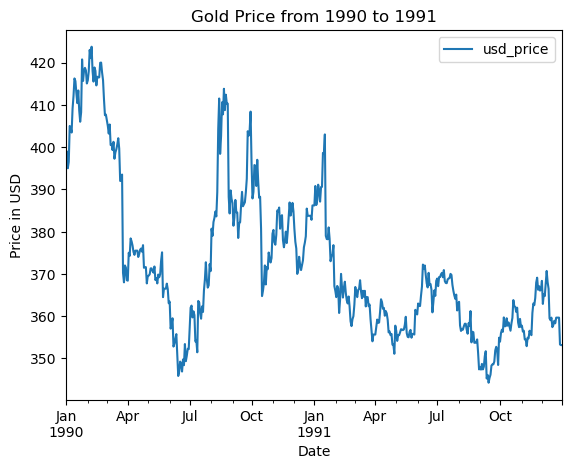

In [ ]:
gold_data_usd['1990-01-01':'1991-12-31'].plot()
plt.title('Gold Price from 1990 to 1991')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.show()


### Plot the US debt from 1995 to 1996

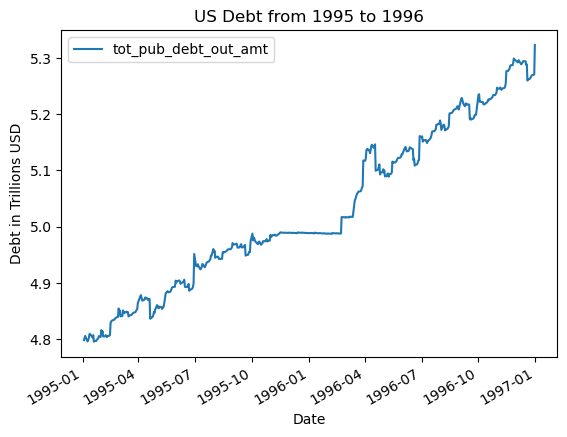

In [ ]:
debt_to_penny_df['1995':'1996'].plot()
plt.title('US Debt from 1995 to 1996')
plt.xlabel('Date')
plt.ylabel('Debt in Trillions USD')
plt.show()

### Plot US debt to penny data aside gold price data during the same period going from 1979 to 2024

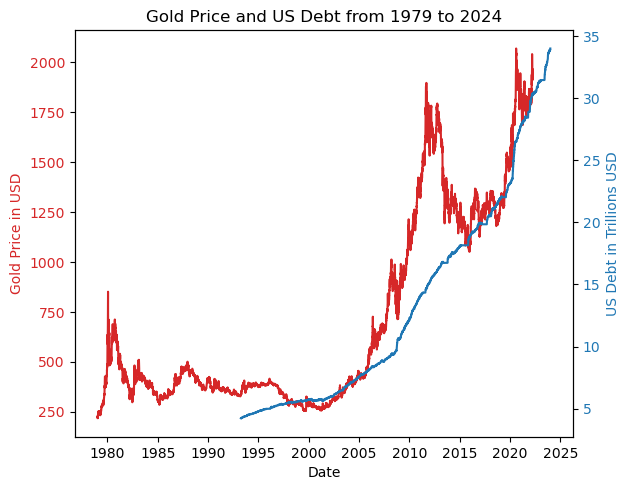

In [128]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Gold Price in USD', color=color)
ax1.plot(gold_data_usd["usd_price"], color=color)
#ax1.plot(gold_data_usd['1993':'2002'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('US Debt in Trillions USD', color=color)
ax2.plot(debt_to_penny_df["tot_pub_debt_out_amt"], color=color)
#ax2.plot(debt_to_penny_df['1993':'2002'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Gold Price and US Debt from 1979 to 2024')
plt.show()



## Compute correlations between gold prices and US debt

In [129]:
# Define the periods
periods = {
    '1993-2000': ('1993-01-01', '2000-12-31'),
    '2000-2008': ('2000-01-01', '2008-12-31'),
    '2008-2011': ('2008-01-01', '2011-12-31'),
    '2011-2019': ('2011-01-01', '2019-12-31')
}

In [130]:
# Calculate daily returns
gold_data_usd['gold_daily_return'] = gold_data_usd['usd_price'].pct_change()
debt_to_penny_df['debt_daily_return'] = debt_to_penny_df['tot_pub_debt_out_amt'].pct_change()

In [132]:
columns = pd.MultiIndex.from_product([["gold_vs_debt"],["correlation","correlation_daily_return"]])
correlations = pd.DataFrame(data=[], index=periods.keys(), columns=columns)


# Calculate and print the correlation for each period
for period, (start_date, end_date) in periods.items():
    gold_period = gold_data_usd[start_date:end_date]
    debt_period = debt_to_penny_df[start_date:end_date]
    
    # Merge the dataframes on the date index
    merged_data = pd.merge(gold_period, debt_period, left_index=True, right_index=True)
    
    # Calculate the correlation
    correlation = merged_data['usd_price'].corr(merged_data['tot_pub_debt_out_amt'])
    correlations.loc[period,("gold_vs_debt","correlation")] = correlation
    
    #print(f"Correlation between gold prices and US debt from {period}: {correlation}")

    # Calculate the correlation of daily returns
    correlation_dr = merged_data['gold_daily_return'].corr(merged_data['debt_daily_return'])
    correlations.loc[period,("gold_vs_debt","correlation_daily_return")] = correlation_dr
    
    #print(f"Correlation between daily returns of gold prices and US debt from {period}: {correlation_dr}")

correlations

gold_vs_debt                         
           correlation correlation_daily_return
1993-2000    -0.812198                 0.004106
2000-2008     0.943344                -0.000451
2008-2011     0.912345                 0.000132
2011-2019    -0.499183                 0.030921

### Merging gold and debt data in one dataframe

In [136]:
data = gold_data_usd.merge(debt_to_penny_df, how="outer", left_index=True, right_index=True)
data

,usd_price,gold_daily_return,tot_pub_debt_out_amt,debt_daily_return
1979-01-01,226.00,NaN,NaN,NaN
1979-01-02,226.80,0.003540,NaN,NaN
1979-01-03,218.60,-0.036155,NaN,NaN
1979-01-04,223.15,0.020814,NaN,NaN
1979-01-05,225.50,0.010531,NaN,NaN
...,...,...,...,...
2023-12-22,NaN,NaN,33.901019,0.000394
2023-12-26,NaN,NaN,33.905473,0.000131
2023-12-27,NaN,NaN,33.896083,-0.000277
2023-12-28,NaN,NaN,33.911228,0.000447
